# Build Sequence Model

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from lightgbm import LGBMRegressor
from sklearn.base import clone
from sklearn.metrics import r2_score
import optuna
from joblib import Parallel, delayed
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot

from datasets import dataset_list
from core import (get_predictive_performance,
                  plot_spearman_heatmap,
                  plot_model_performance,
                  setup_plots,
                  get_feature_df,
                  get_performance_type_df,
                  plot_performance_type_df)

In [2]:
setup_plots()

In [3]:
def train_test_model(train_df, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from get_feature_df
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    X_train = get_feature_df(train_df)
    y_train = train_df['sgRNA Activity']
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def get_fold_predictions(fold, fold_df,
                         base_model=LGBMRegressor(random_state=7, n_jobs=8),
                         combine_datasets=None, leave_one_out=False, model_name=None):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param combine_datasets: list of str
    :param leave_one_out: bool
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = get_feature_df(fold_test_data)
    test_prediction_list = []
    if combine_datasets is not None:
        train_df = fold_train_data[fold_train_data.dataset.isin(combine_datasets)].reset_index(drop=True)
        model = clone(base_model)
        if model_name is None:
            model_name = ' + '.join(combine_datasets)
        dataset_test_predictions = train_test_model(train_df, model_name, fold,
                                                    model, fold_test_data, X_test)
        test_prediction_list.append(dataset_test_predictions)
    elif leave_one_out:
        for dataset in fold_train_data['dataset'].unique():
            train_df = fold_train_data[fold_train_data['dataset'] != dataset].reset_index(drop=True)
            model = clone(base_model)
            model_name = 'No ' + dataset
            dataset_test_predictions = train_test_model(train_df, model_name, fold,
                                                        model, fold_test_data, X_test)
            test_prediction_list.append(dataset_test_predictions)
    else:  # train each dataset separately
        for dataset, dataset_df in fold_train_data.groupby('dataset'):
            dataset_df = dataset_df.reset_index(drop=True)
            # Join together top training set and current dataset
            model = clone(base_model)
            dataset_test_predictions = train_test_model(dataset_df, dataset, fold, model, fold_test_data, X_test)
            test_prediction_list.append(dataset_test_predictions)
    return test_prediction_list

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

## Cross-Validation Iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

>This cross-validation object is a variation of StratifiedKFold attempts to return stratified folds with
> non-overlapping groups. The folds are made by preserving the percentage of samples for each class.

>The same group will not appear in two different folds (the number of distinct groups has to be at least equal to
> the number of folds).

>The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such
> that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to
> create folds which preserve the percentage of samples for each class as much as possible given the
> constraint of non-overlapping groups between splits.

In our case, we define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [6]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df['tracr'] = ds.tracr
    sg_df_list.append(sg_df)

sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,2,True,Munoz2016,18048
1,4,True,Munoz2016,16888
2,0,True,Munoz2016,16828
3,3,True,Munoz2016,16425
4,1,True,Munoz2016,16355
...,...,...,...,...
58,1,False,Wang2014,226
59,2,False,Wang2014,205
60,4,False,Wang2014,156
61,0,False,Wang2014,149


In [8]:
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n'))

,cv,dataset,n
0,2,Kim2019_train,2
1,2,Doench2016,2
2,4,Wang2014,2
3,4,Munoz2016,2
4,4,Kim2019_train,2
5,4,Doench2016,2
6,3,Xiang2021,2
7,3,Wang2014,2
8,3,Munoz2016,2
9,3,Kim2019_train,2


The size of the training and testing sets are approximately equal across folds,
with training sets varying between 13,107 (fold 2) - 15,847 (fold 3) sgRNAs and testing sets varying
between 2,707 (fold 3) - 5,447 (fold 2) sgRNAs


In [9]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
6,0,False,10931
3,0,True,40156
5,1,False,11016
4,1,True,40071
9,2,False,8364
0,2,True,42723
7,3,False,10713
2,3,True,40374
8,4,False,10063
1,4,True,41024


Indeed, each gene target (gene) only appears in one set in each fold

In [10]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Train each dataset separately
Now we'll move onto training and first we'll train each dataset separately

In [11]:
single_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    single_test_prediction_list.extend(get_fold_predictions(fold, df))
    print('\n')

single_predictive_performance, single_agg_perforamnce = get_predictive_performance(single_test_prediction_list,
                                                                                   'sgRNA Activity')

Fold: 0


100%|██████████| 9088/9088 [00:23<00:00, 393.15it/s]




Fold: 1


100%|██████████| 9164/9164 [00:23<00:00, 386.74it/s]




Fold: 2


100%|██████████| 9138/9138 [00:23<00:00, 389.92it/s]




Fold: 3


100%|██████████| 9087/9087 [00:23<00:00, 393.04it/s]




Fold: 4


100%|██████████| 9111/9111 [00:23<00:00, 393.30it/s]


Importantly, all training datasets are successful at predicting held-out test data

In [12]:
single_agg_perforamnce

,model_name,mean_spearman,std_spearman,median_spearman
0,Kim2019_train,0.557558,0.168452,0.570475
1,Xiang2021,0.541744,0.191920,0.586310
2,Wang2014,0.424742,0.135414,0.468359
3,Munoz2016,0.422408,0.064037,0.430896
4,Doench2016,0.407368,0.107894,0.422331
5,Doench2014_human,0.400774,0.128335,0.414861
6,Doench2014_mouse,0.390706,0.103941,0.412460


Saving 3.5 x 2.2 in image.
Filename: ../figures/seq_heatmap_single.pdf


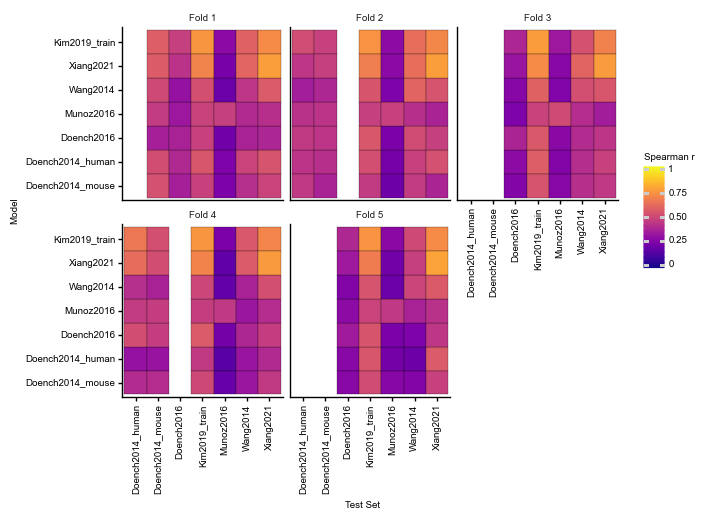

<ggplot: (8779795154812)>

In [13]:
g = plot_spearman_heatmap(single_predictive_performance)
g.save('../figures/seq_heatmap_single.pdf', width=3.5, height=2.2)
g

Saving 3.75 x 2.2 in image.
Filename: ../figures/seq_point_single.pdf
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


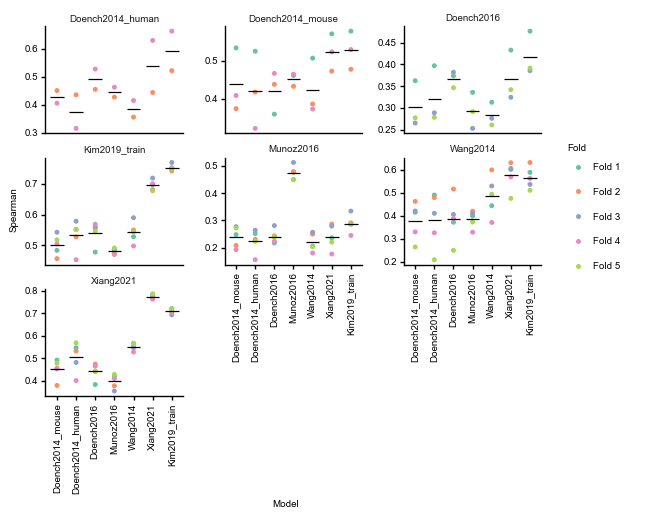

<ggplot: (8779726918054)>

In [14]:
g = plot_model_performance(single_predictive_performance)
g.save('../figures/seq_point_single.pdf', width=3.75, height=2.2)
g

We see a large gap in the training set size, with the two largest datasets that use the Hsu 2013 tracr
showing the best performance

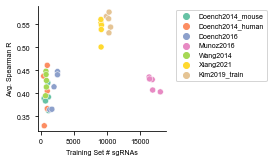

In [15]:
dataset_size_performance = (cv_train_data_counts[cv_train_data_counts['train']]
                            .merge(single_predictive_performance, how='inner',
                                   left_on=['dataset', 'cv'], right_on=['model_name', 'fold'])
                            .groupby(['model_name', 'cv'])
                            .agg(spearman_r = ('spearman_r', 'mean'),
                                 n_guides = ('n', 'first'))
                            .reset_index())
plt.subplots(figsize=(2.3, 2.3))
sns.scatterplot(data=dataset_size_performance,
                x='n_guides', y='spearman_r', hue='model_name',
                palette='Set2')
plt.xlabel('Training Set # sgRNAs')
plt.ylabel('Avg. Spearman R')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
sns.despine()

In [16]:
dataset_size_performance

,model_name,cv,spearman_r,n_guides
0,Doench2014_mouse,0,0.422868,1090
1,Doench2014_mouse,1,0.388777,518
2,Doench2014_mouse,2,0.391846,1169
3,Doench2014_mouse,3,0.383213,730
4,Doench2014_mouse,4,0.362278,1169
5,Doench2014_human,0,0.460755,995
6,Doench2014_human,1,0.437351,452
7,Doench2014_human,2,0.404902,995
8,Doench2014_human,3,0.329274,543
9,Doench2014_human,4,0.366578,995


## Combining training datasets

If we merge the training datasets, can we improve our performance?

We'll combine all training sets sine they all have predictive power on their own

In [17]:
top_training_set = single_agg_perforamnce['model_name'][0]
print('Top training set: ' + top_training_set)

Top training set: Kim2019_train


In [18]:
combine_datasets =  list(single_agg_perforamnce['model_name'])

In [19]:
top_combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    top_combined_test_prediction_list.extend(get_fold_predictions(fold, df, combine_datasets=combine_datasets,
                                                                  model_name='All train data'))
    print('\n')

print('Reference model: ' + str(top_training_set))
top_training_prediction_list = [df for df in single_test_prediction_list if (df.model_name == top_training_set).all()]
top_combined_predictive_performance, top_combined_agg_performance = get_predictive_performance(
    top_combined_test_prediction_list + top_training_prediction_list, 'sgRNA Activity')

Fold: 0


100%|██████████| 40156/40156 [01:43<00:00, 388.30it/s]




Fold: 1


100%|██████████| 40071/40071 [01:43<00:00, 388.61it/s]




Fold: 2


100%|██████████| 42723/42723 [01:51<00:00, 383.97it/s]




Fold: 3


100%|██████████| 40374/40374 [01:42<00:00, 392.34it/s]




Fold: 4


100%|██████████| 41024/41024 [01:44<00:00, 392.44it/s]




Reference model: Kim2019_train


In [20]:
top_combined_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All train data,0.603399,0.130360,0.602253
1,Kim2019_train,0.557558,0.168452,0.570475


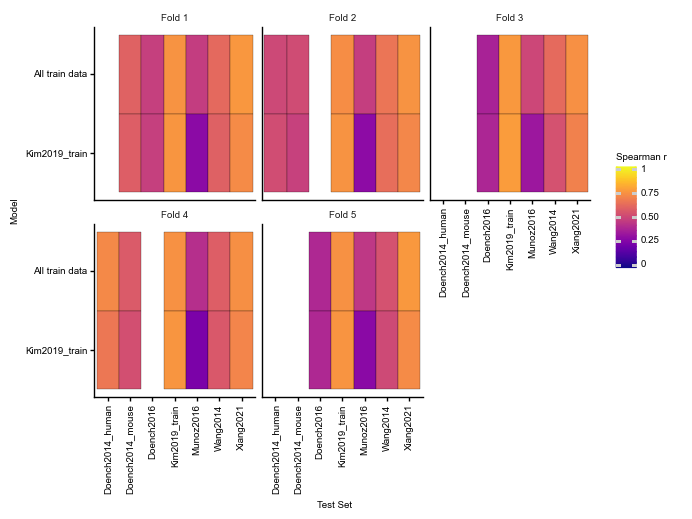

<ggplot: (8779528750394)>

In [21]:
plot_spearman_heatmap(top_combined_predictive_performance)

Saving 3.5 x 2.2 in image.
Filename: ../figures/seq_combined_model_performance.pdf
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors (['#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


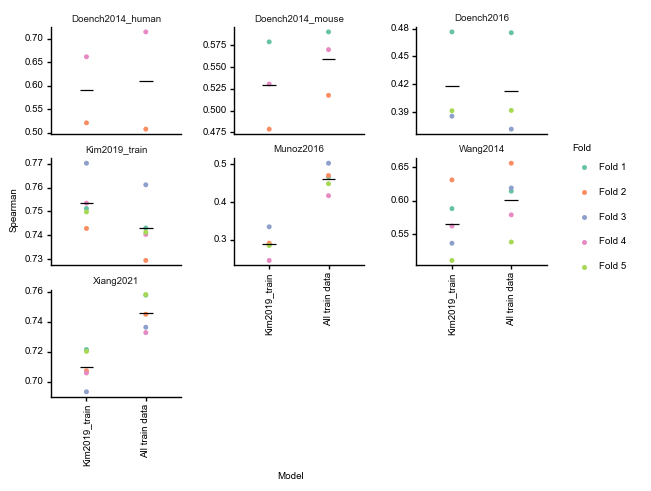

<ggplot: (8779444289175)>

In [22]:
g = plot_model_performance(top_combined_predictive_performance, wspace=0.4)
g.save('../figures/seq_combined_model_performance.pdf', width=3.5, height=2.2)
g

In [23]:
leave_one_out_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: '+ str(fold))
    leave_one_out_prediction_list.extend(get_fold_predictions(fold, df, leave_one_out=True))
    print('\n')

combined_predictive_performance, combined_agg_performance = get_predictive_performance((leave_one_out_prediction_list +
                                                                                        top_combined_test_prediction_list +
                                                                                        top_training_prediction_list),
                                                                                       'sgRNA Activity')

Fold: 0


100%|██████████| 31068/31068 [01:20<00:00, 387.08it/s]




Fold: 1


100%|██████████| 30907/30907 [01:21<00:00, 378.65it/s]




Fold: 2


100%|██████████| 33585/33585 [01:26<00:00, 389.27it/s]




Fold: 3


100%|██████████| 31287/31287 [01:19<00:00, 393.05it/s]




Fold: 4


100%|██████████| 31913/31913 [01:23<00:00, 382.45it/s]


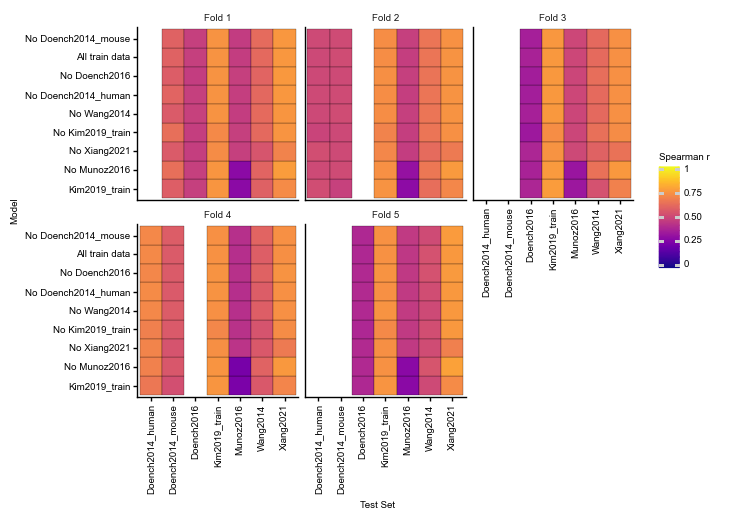

<ggplot: (8779733093142)>

In [25]:
plot_spearman_heatmap(combined_predictive_performance)

You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


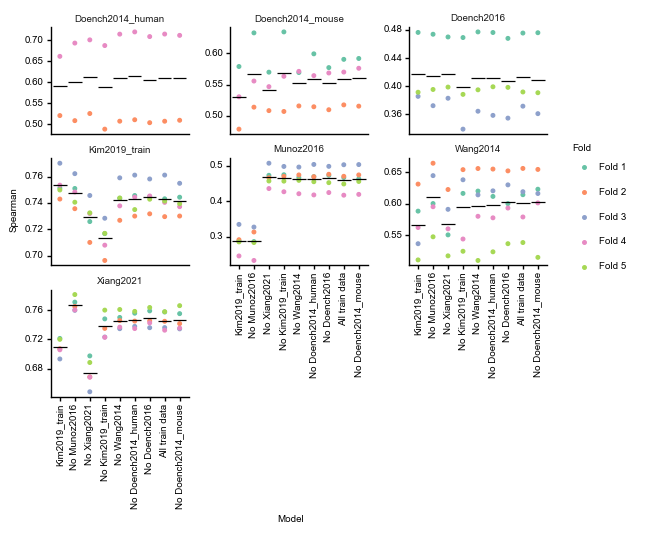

<ggplot: (8779446402317)>

In [26]:
plot_model_performance(combined_predictive_performance)

## Sequence Model Hyperparameter Tuning

Using the combined datasets, we'll try different model architectures and use hyperparameter tuning.
For the hyperparmeter tuning, we'll use the [optuna library](https://optuna.readthedocs.io/en/stable/index.html),
which by default uses the Tree-structured Parzen Estimator to search the hyperparameter space.

In [27]:
n_trials = 50

### LightGBM

In [26]:
def lgbm_training_iteration(fold_df, X, train_index, test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    X_train_val = X.iloc[train_index,:].reset_index(drop=True)
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.2, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = X.iloc[test_index,:]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df, X):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples)
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, X, train_index, test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [27]:
hyperparameter_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    train_df = fold_train_data.copy()
    X_train_val = get_feature_df(train_df)
    objective = get_lgbm_objective(fold_train_data, X_train_val)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.2, random_state=7)
    model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                          **trial.params)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = get_feature_df(fold_test_data)
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All + hyperparameter tuning'
    test_predictions['fold'] = fold
    hyperparameter_prediction_list.append(test_predictions)

[I 2021-07-19 12:27:18,398] A new study created in memory with name: no-name-67616e72-be59-4e0e-94b7-b2a0006e2cf4


Fold: 0


[I 2021-07-19 12:30:05,394] Trial 0 finished with value: 0.40712320239210414 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.40712320239210414.
[I 2021-07-19 12:31:03,190] Trial 1 finished with value: 0.40938023121957484 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.40938023121957484.
[I 2021-07-19 12:31:56,540] Trial 2 finished with value: 0.40990637669804936 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 2 with value: 0.40990637669804936.
[I 2021-07-19 12:32:37,366] Trial 3 finished with value: 0.4039050813343942 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 2 with value: 0.40990637669804936.
[I 2021-07-19 12:33:24,812] Trial 4 finished with value: 0.4116527444335265 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 4 with value: 0.4116527444335265.
[I 2021-07-19 12:34:15,012] Trial 5 finished with value: 0.41

Number of finished trials: 50
Training Time: 0:41:52.786778
Best trial:
  Value: 0.41166755813941824
  Params: 
    num_leaves: 106
    min_child_samples: 126
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.579643
Early stopping, best iteration is:
[1937]	valid_0's l2: 0.566062


[I 2021-07-19 13:12:03,679] A new study created in memory with name: no-name-5d87ebc1-db92-446f-a152-63d28e7ba1be


Fold: 1


[I 2021-07-19 13:14:54,811] Trial 0 finished with value: 0.41979461969056164 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.41979461969056164.
[I 2021-07-19 13:15:55,218] Trial 1 finished with value: 0.4240461112819747 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.4240461112819747.
[I 2021-07-19 13:16:43,751] Trial 2 finished with value: 0.4220214978619806 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 1 with value: 0.4240461112819747.
[I 2021-07-19 13:17:29,741] Trial 3 finished with value: 0.4129090756580734 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 1 with value: 0.4240461112819747.
[I 2021-07-19 13:18:19,205] Trial 4 finished with value: 0.424337683066412 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 4 with value: 0.424337683066412.
[I 2021-07-19 13:19:14,817] Trial 5 finished with value: 0.424162164

Number of finished trials: 50
Training Time: 0:41:35.191714
Best trial:
  Value: 0.4247969951076196
  Params: 
    num_leaves: 69
    min_child_samples: 218
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.589268
[2000]	valid_0's l2: 0.563965
Early stopping, best iteration is:
[2605]	valid_0's l2: 0.559459


[I 2021-07-19 13:56:39,417] A new study created in memory with name: no-name-805b7ba0-71b3-4daa-866b-a5e8173b13d9


Fold: 2


[I 2021-07-19 13:59:55,745] Trial 0 finished with value: 0.4111817884688961 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.4111817884688961.
[I 2021-07-19 14:00:51,144] Trial 1 finished with value: 0.4125947564092723 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.4125947564092723.
[I 2021-07-19 14:01:54,928] Trial 2 finished with value: 0.412953412316942 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 2 with value: 0.412953412316942.
[I 2021-07-19 14:02:40,119] Trial 3 finished with value: 0.40241868070710946 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 2 with value: 0.412953412316942.
[I 2021-07-19 14:03:37,216] Trial 4 finished with value: 0.41332279818870765 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 4 with value: 0.41332279818870765.
[I 2021-07-19 14:04:37,941] Trial 5 finished with value: 0.413349684

Number of finished trials: 50
Training Time: 0:45:05.557483
Best trial:
  Value: 0.4148113787531239
  Params: 
    num_leaves: 69
    min_child_samples: 243
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.600899
[2000]	valid_0's l2: 0.577275
Early stopping, best iteration is:
[2291]	valid_0's l2: 0.575306


[I 2021-07-19 14:44:46,397] A new study created in memory with name: no-name-462e90aa-0571-4529-b2ba-0a4ecd161673


Fold: 3


[I 2021-07-19 14:47:38,436] Trial 0 finished with value: 0.4143585052153397 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.4143585052153397.
[I 2021-07-19 14:48:27,209] Trial 1 finished with value: 0.4179985815829103 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.4179985815829103.
[I 2021-07-19 14:49:12,178] Trial 2 finished with value: 0.41665430447149676 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 1 with value: 0.4179985815829103.
[I 2021-07-19 14:49:50,563] Trial 3 finished with value: 0.40838331539759454 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 1 with value: 0.4179985815829103.
[I 2021-07-19 14:50:48,053] Trial 4 finished with value: 0.4186752919209196 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 4 with value: 0.4186752919209196.
[I 2021-07-19 14:51:47,604] Trial 5 finished with value: 0.4171008

Number of finished trials: 50
Training Time: 0:48:19.775745
Best trial:
  Value: 0.4186752919209196
  Params: 
    num_leaves: 74
    min_child_samples: 132
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.576434
[2000]	valid_0's l2: 0.559033
Early stopping, best iteration is:
[2189]	valid_0's l2: 0.557437


[I 2021-07-19 15:36:21,540] A new study created in memory with name: no-name-6a7d0761-48ca-4f43-b01e-1d7e91f1c34a


Fold: 4


[I 2021-07-19 15:39:53,017] Trial 0 finished with value: 0.41522899572256866 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.41522899572256866.
[I 2021-07-19 15:41:21,069] Trial 1 finished with value: 0.41847009011741737 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.41847009011741737.
[I 2021-07-19 15:42:46,911] Trial 2 finished with value: 0.4159495900971072 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 1 with value: 0.41847009011741737.
[I 2021-07-19 15:43:43,915] Trial 3 finished with value: 0.4101405095585677 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 1 with value: 0.41847009011741737.
[I 2021-07-19 15:44:55,805] Trial 4 finished with value: 0.41874139587421755 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 4 with value: 0.41874139587421755.
[I 2021-07-19 15:46:31,936] Trial 5 finished with value: 0.4

Number of finished trials: 50
Training Time: 1:05:47.501526
Best trial:
  Value: 0.4198706305911126
  Params: 
    num_leaves: 61
    min_child_samples: 120
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.577943
[2000]	valid_0's l2: 0.558799
Early stopping, best iteration is:
[2613]	valid_0's l2: 0.554774


In [55]:
lgbm_predictive_performance, lgbm_agg_performance = get_predictive_performance(
    top_combined_test_prediction_list + hyperparameter_prediction_list, 'sgRNA Activity')

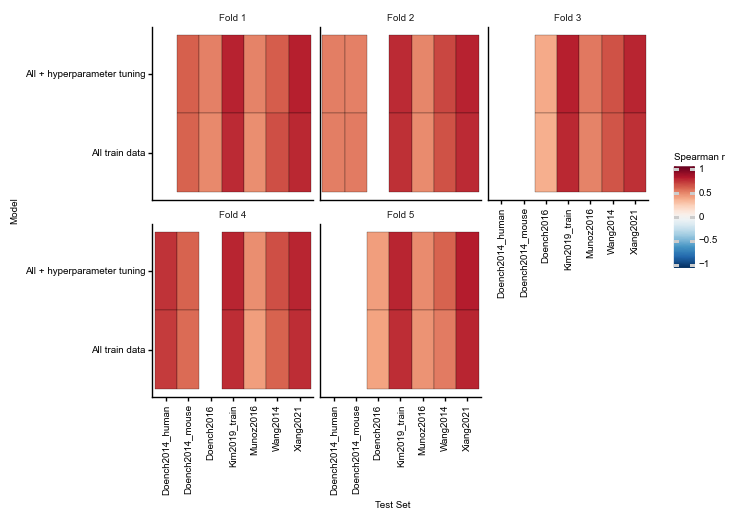

<ggplot: (8784388882104)>

In [56]:
plot_spearman_heatmap(lgbm_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 2.2 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_lgbm_tpe_model_performance.pdf
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:6

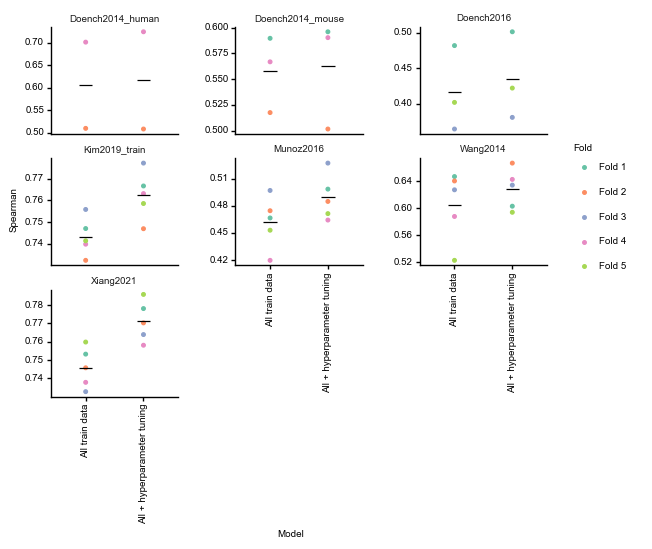

<ggplot: (8784626276235)>

In [57]:
g = plot_model_performance(lgbm_predictive_performance, wspace=0.45)
g.save('../figures/seq_lgbm_tpe_model_performance.pdf', width=3.5, height=2.2)
g

### All Models

In [58]:
all_predictive_performance, all_agg_performance = get_predictive_performance(
    single_test_prediction_list + top_combined_test_prediction_list + leave_one_out_prediction_list + hyperparameter_prediction_list,
    'sgRNA Activity')

In [59]:
all_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All + hyperparameter tuning,0.624145,0.130257,0.618184
1,All train data,0.603953,0.129685,0.608184
2,No Doench2014_human,0.603541,0.129311,0.616962
3,No Wang2014,0.602954,0.129246,0.611376
4,No Doench2014_mouse,0.602791,0.129088,0.608389
5,No Doench2016,0.602171,0.130188,0.609427
6,No Kim2019_train,0.593352,0.125121,0.613617
7,No Xiang2021,0.583488,0.110659,0.576692
8,No Munoz2016,0.577138,0.180173,0.613071
9,Kim2019_train,0.555194,0.167813,0.572504


In [75]:
g = plot_spearman_heatmap(all_predictive_performance)
g.save('../figures/seq_all_performance_heatmap.pdf', width=5, height=5)
g

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 5 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_all_performance_heatmap.pdf


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_all_performance.pdf
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff', '#000000ff'

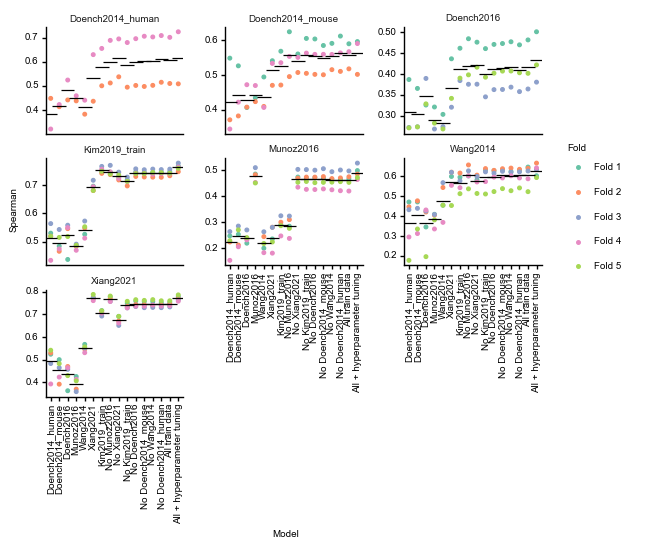

<ggplot: (8784989693678)>

In [69]:
g = plot_model_performance(all_predictive_performance)
g.save('../figures/seq_all_performance.pdf', width=7, height=5)
g

In [92]:
training_group_dict = {'model_name': ['All + hyperparameter tuning', 'All train data',
                                      'No Doench2014_human', 'No Wang2014',
                                      'No Doench2014_mouse', 'No Doench2016',
                                      'No Kim2019_train', 'No Xiang2021',
                                      'No Munoz2016', 'Kim2019_train',
                                      'Xiang2021', 'Wang2014', 'Munoz2016',
                                      'Doench2016', 'Doench2014_mouse',
                                      'Doench2014_human'],
                       'model_type': ['all'] * 2 +
                                     ['leave one out']*7 +
                                     ['single']*7}

all_performance_type_df = get_performance_type_df(training_group_dict, all_predictive_performance,
                                                  all_agg_performance)

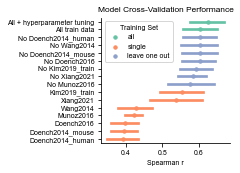

In [94]:
plot_performance_type_df(all_performance_type_df, 'Training Set')

gpplot.savefig('../figures/seq_cv_performance_pointplot.pdf')